# Exponential Smoothing from scratch with `scipy` and animations with `matplotlib`

Here we'll create a forecast using simple exponential smoothing with optimization implemented in `scipy.optimize`.

Simple exponential smoothing has a single parameter $\alpha$ that represents how much to weight recent observations. A value of $\alpha=1$ would create a naive model that uses the most recent observation as the forecast for all future periods.

Following the notation in [Hyndman's Forecasting: Principles and Practice](https://otexts.com/fpp2/ses.html):

$$
\begin{aligned}
\hat{y}_{t+h|t} &= \ell_t && \text{(Forecast equation)}\\
\quad \ell_t &= \alpha y_t + (1- \alpha)\ell_{t-1} && \text{(Smoothing equation)}
\end{aligned}
$$

Where $\ell$ is the 'local level' component.

For any time $T$ and initial level $\ell_0$, a one-step ahead forecast (at $T+1$) would look like the following:

$$
\hat{y}_{T+1|T} = \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^T \ell_0
$$

Our optimization problem involves finding the value of $\alpha$ that minimizes the SSE between the forecast and the observed data. 

We'll use the air passengers dataset from [a github repo for a time series forecasting workshop with Aileen Nielsen](https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv)

In [130]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

filepath = "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"

df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [83]:
# Create the exponential smoothing function that takes a parameter and data as input

def exp_smooth(data, alpha: float, l0):
    """Simple Exponential Smoothing as a list comprehension"""
    result = []
    for j,y in enumerate(data):
        if j==0:
            result.append(alpha * y + (1-alpha) * l0)
        else:
            result.append(alpha * y + (1-alpha) * result[j-1])
    # result = [alpha * y + (1-alpha) * l0 if j==0 else alpha * y + (1-alpha) * result[j-1] for j,y in enumerate(data)]
    return pd.Series(result)

In [81]:
passengers = df["#Passengers"].values

In [84]:
%%timeit

forecast = exp_smooth(passengers, 0.5, passengers[0])

406 µs ± 5.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Next, let's calculate the SSE between the forecast and the actuals:

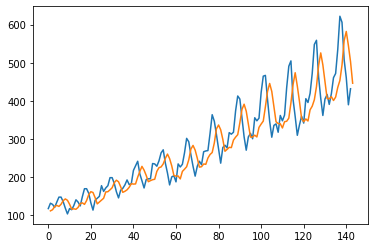

In [118]:
alpha = 0.5
forecast = exp_smooth(passengers, alpha, passengers[0])
# forecast.shift(1)

actuals = passengers[1:]
# 1 step ahead forecast
forecast = forecast.shift(1)[1:]

# doublecheck with a plot
plt.plot(actuals)
plt.plot(forecast)

We can also visualize the SSE at various values of $\alpha$:

In [146]:
def sse(params: iter, data: iter):
    alpha = params[0]
    l0 = params[1]
    forecast = exp_smooth(data, alpha, l0)
    actuals = data[1:]
    forecast = forecast.shift(1)[1:]
    return ((forecast - actuals)**2).sum()

SSE = sse([0.5, passengers[0]], passengers)
alphas = np.linspace(0,1,1000)
errors = [sse([a, passengers[0]], passengers) for a in alphas]

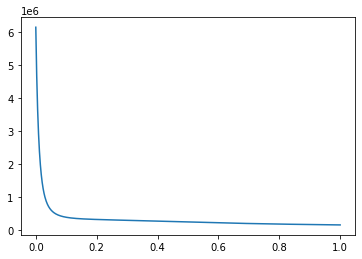

In [147]:
plt.plot(alphas, errors)

In [154]:
# The best we can get so far
min(errors)

162504.0

So a more naive model would be best here. Let's see the result of the optimization problem:

In [157]:
opt_alpha = minimize(sse, x0=[0.5, passengers[0]], bounds=((0, 1), (0,np.inf)), args=(passengers))
opt_alpha

      fun: 162504.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-98908.76486093,      0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([  1.        , 138.26962191])

And indeed the minimization problem finds that $\alpha=1$ is best and sets up a value of $\ell_0 \approx 138$

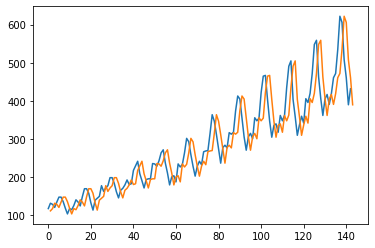

In [161]:
opt_forecast = exp_smooth(passengers, 1, 138.27)

# 1 step ahead forecast
opt_forecast = opt_forecast.shift(1)[1:]

# Plot this optimal value
plt.plot(actuals)
plt.plot(opt_forecast)